In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from typing import Tuple

import seaborn as sns
from utils.colors import DTU_COLOR_HEX, DTU_BIN, DTU_BIN_HC
colors = list(DTU_COLOR_HEX.values())
sns.set_palette(sns.color_palette(colors))
CM_DTU_BIN = LinearSegmentedColormap.from_list('dtu_bin', DTU_BIN, N=2)
import pickle

from models.daypattern import DayPatternSim, ACTIVITIES
from models.prim import PrimClassifier, score, coverage, density
from models.sampler import Sampler
from utils.data_loader import load_metadata, load_betas

%matplotlib inline

In [2]:
ACTIVITY = 'LeisureT'
THRESHOLD = 7900
filename_pb = '1687875536.595003'

df, betas, bounds = load_metadata()

def open_file(folder:str, filename:str) -> pd.DataFrame:
    betas_dp = load_betas('dp')
    names = list(betas_dp.keys())[:-1]
 

    data = pd.read_csv(f'data/out/{folder}/{filename}.csv')
    data = data.drop(['Unnamed: 0'], axis=1)
    # data_standardized = (data - data.mean()) / data.std()
    cube = data[names]
    counts = data[ACTIVITY]
    return cube, counts

In [3]:
def get_increase(counts:pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    count_mean = np.empty(100)
    x = np.linspace(0,len(counts)-1000,100)
    x = [round(item) - 1 for item in x]
    for k,i in enumerate(x):
        if k < 10:
            count_mean[k] = max(counts.iloc[1000:1000+i].mean(), counts.iloc[:1000+i].mean())
        else:
            count_mean[k] = counts.iloc[1000:1000+i].mean()
    return x, count_mean

In [4]:
def get_limits(cube, counts):
    pc = PrimClassifier(
        activity = ACTIVITY,
        threshold = THRESHOLD,
        peel_alpha=0.1
    )
    box = pc.fit(cube, counts)
    y_bin = pc._compute_bin(counts)
    y_pred = pc.predict(cube)
    limits = box.limits
    return limits
    

def get_box_limits(cube, counts, feature:str):
    return get_limits(cube, counts).transpose()[feature]

In [5]:
filename_pb = 'pb_100'
folder_pb = 'PB'
cube_pb, counts_pb = open_file(folder_pb, filename_pb)
x_pb, count_mean_pb = get_increase(counts_pb)

In [6]:
filename_qd = 'qd_100'
folder_qd = 'QD'
cube_qd, counts_qd = open_file(folder_qd, filename_qd)
x_qd, count_mean_qd = get_increase(counts_qd)

In [7]:
folder_lhs, filename_lhs = 'LHS', '1685970373.084523'
cube_lhs, counts_lhs = open_file(folder_lhs, filename_lhs)
x_lhs, count_mean_lhs = get_increase(counts_lhs)

In [8]:
filename_bo = 'ax_ei_100'
folder_bo = 'BO'
cube_bo, counts_bo = open_file(folder_bo, filename_bo)
x_bo, count_mean_bo = get_increase(counts_bo)

Text(0, 0.5, 'Average number of leisure trips')

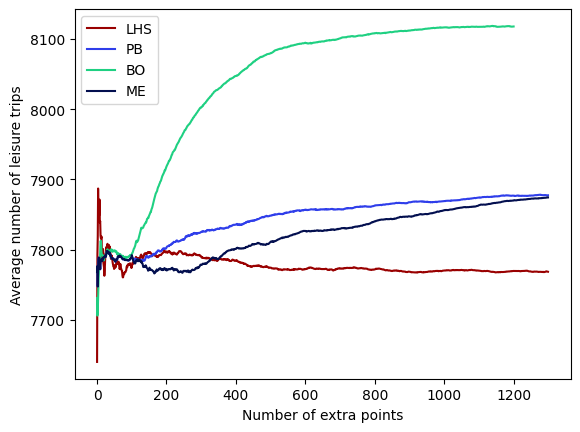

In [9]:
plt.plot(counts_lhs.expanding().mean().iloc[:1300], label='LHS')
plt.plot(counts_pb.expanding().mean(), label='PB')
plt.plot(counts_bo.expanding().mean(), label='BO')
plt.plot(counts_qd.expanding().mean(), label='ME')
plt.legend()
plt.xlabel('Number of extra points')
plt.ylabel('Average number of leisure trips')

In [10]:
color_gradient = {
    'LHS': .9,
    'PB': .7,
    'BO': .5,
    'ME': 1
}

def plot_box(cube, counts, mode:str, feature:str):
    limits = get_box_limits(cube,counts,feature)
    x = np.linspace(0,1,1000)
    y1 = limits.iloc[0] * np.ones(1000)
    y2 = limits.iloc[1] * np.ones(1000)
    plt.plot(x,y1, c=colors[list(color_gradient.keys()).index(f'{mode}')])
    plt.plot(x,y2, c=colors[list(color_gradient.keys()).index(f'{mode}')])
    plt.fill_between(x, y1, y2, alpha=1, label=f'{mode}', color=colors[list(color_gradient.keys()).index(f'{mode}')])

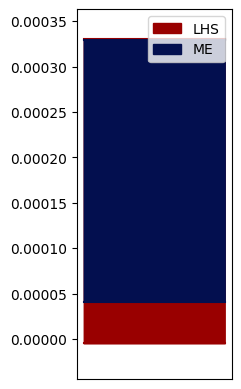

In [11]:
feature = 'fam_income_travel'
ylim_min = bounds[bounds['name'] == f'{feature}']['min'].values[0] * 1.1
ylim_max = bounds[bounds['name'] == f'{feature}']['max'].values[0] * 1.1

plt.figure().set_figwidth(2)

try:
    plot_box(cube_lhs, counts_lhs, 'LHS', feature)
except:
    pass
try:
    plot_box(cube_qd, counts_qd, 'ME', feature)
except:
    pass
try:
    plot_box(cube_pb, counts_pb, 'PB', feature)
except:
    pass

try:
    plot_box(cube_bo, counts_bo, 'BO', feature)
except:
    pass

plt.ylim(ylim_min, ylim_max)
plt.xticks([], [])
# plt.ylabel(f'{feature}')
plt.legend(loc='upper right')
plt.show()

In [12]:
limits_lhs_base = get_limits(cube_lhs,counts_lhs)
limits_pb = get_limits(cube_pb, counts_pb)
limits_bo = get_limits(cube_bo, counts_bo)
limits_qd = get_limits(cube_qd, counts_qd)

In [13]:
def get_distance(limits, base):
    df = base.join(limits, lsuffix='_base', how='outer')
    df = df.fillna(0)
    df['distance'] = (df['min'] - df['min_base'])**2 + (df['max'] - df['max_base'])**2
    return np.sqrt(df['distance'].sum())

In [16]:
N_POINTS = 100
extra_points = np.linspace(0,4900,N_POINTS)
extra_points = [round(item) for item in extra_points]
distance = np.empty((3,N_POINTS))

for iter, item in enumerate(extra_points):
    limits_lhs = get_limits(cube_lhs.iloc[:(100+item)],counts_lhs.iloc[:(100+item)])
    # limits_pb = get_limits(cube_pb.iloc[:(100+item)], counts_pb.iloc[:(100+item)])
    # limits_bo = get_limits(cube_bo.iloc[:(100+item)], counts_bo.iloc[:(100+item)])
    # limits_qd = get_limits(cube_qd.iloc[:(100+item)], counts_qd.iloc[:(100+item)])
    distance[0,iter] = get_distance(limits_pb, limits_lhs)
    # distance[1,iter] = get_distance(limits_bo, limits_lhs)
    
    # distance[2,iter] = get_distance(limits_qd, limits_lhs)

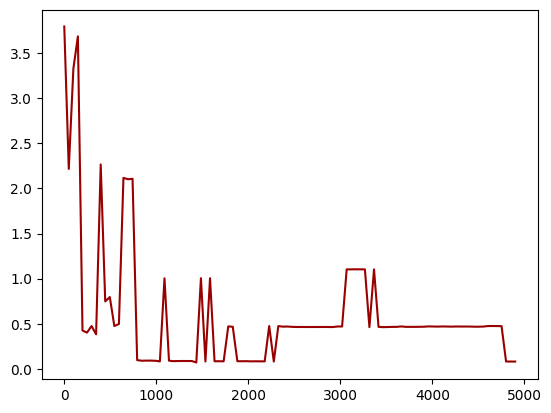

In [17]:
plt.plot(extra_points, distance[0])

In [18]:
def compute_exploration_metric(limits, cube):
    limits_copy = limits.copy()
    limits_copy['width'] = limits_copy['max'] - limits_copy['min']
    bounds['width'] = bounds['max'] - bounds['min']
    bounds.index = bounds['name'].values
    limits_copy = limits_copy.join(bounds['width'], rsuffix='_bounds')
    limits_copy['box_density'] = limits_copy['width'] / limits_copy['width_bounds']
    d, d_gap = np.empty(len(limits_copy)), np.empty(len(limits_copy))
    for k, name in enumerate(limits_copy.index):
        d[k] = cube[cube[name].between(limits_copy['min'][name], limits_copy['max'][name])].shape[0] / cube.shape[0]
        d_gap[k] = (d[k]/limits_copy['box_density'][name] -  1) * 100
    #     print(f"Density of points in the box for feature {name}: {d[k]}, with a gap {round(d_gap[k],2)}%")
    # print("Exploration metric = ", d_gap.mean())
    return d_gap.mean()

In [19]:
N_POINTS

100

In [20]:
N_POINTS_METRICS = 12
def get_metrics_evolution(cube, counts):
    metrics = np.empty((3,N_POINTS_METRICS))
    for i, size in enumerate(np.linspace(100,1200,N_POINTS_METRICS)):
        metrics[0,i] = counts.iloc[:int(size)].mean()
        limits = get_limits(cube.iloc[:int(size)], counts.iloc[:int(size)])
        metrics[1,i] = compute_exploration_metric(limits, cube.iloc[:int(size)])
        metrics[2,i] = get_distance(limits, limits_lhs_base)
    return metrics

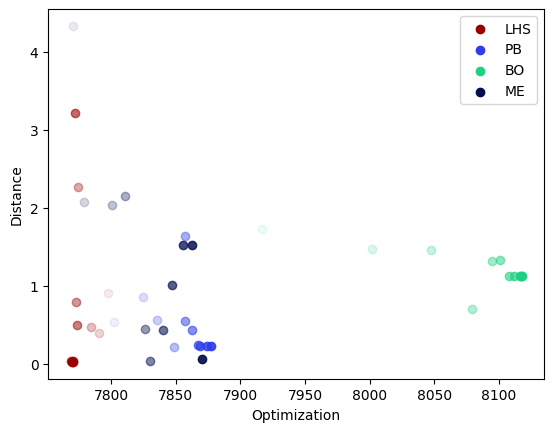

In [21]:
metrics_lhs = get_metrics_evolution(cube_lhs, counts_lhs)
metrics_pb = get_metrics_evolution(cube_pb, counts_pb)
metrics_bo = get_metrics_evolution(cube_bo, counts_bo)
metrics_me = get_metrics_evolution(cube_qd, counts_qd)

for i in range(N_POINTS_METRICS):
    plt.scatter(metrics_lhs[0,i], metrics_lhs[2,i], c="#990000", alpha=i/N_POINTS_METRICS)
    plt.scatter(metrics_pb[0,i], metrics_pb[2,i], c="#2F3EEA", alpha=i/N_POINTS_METRICS)
    plt.scatter(metrics_bo[0,i], metrics_bo[2,i], c="#1FD082", alpha=i/N_POINTS_METRICS)
    plt.scatter(metrics_me[0,i], metrics_me[2,i], c="#030F4F", alpha=i/N_POINTS_METRICS)
    
plt.scatter([], [], c="#990000", alpha=1, label='LHS')
plt.scatter([], [], c="#2F3EEA", alpha=1, label='PB')
plt.scatter([], [], c="#1FD082", alpha=1, label='BO')
plt.scatter([], [], c="#030F4F", alpha=1, label='ME')
plt.legend()
plt.xlabel('Optimization')
plt.ylabel('Distance')
plt.show()

In [22]:
metrics_lhs = np.empty((3,N_POINTS_METRICS))
for i, size in enumerate(np.linspace(100,1200,N_POINTS_METRICS)):
    metrics_lhs[0,i] = counts_lhs.sample(int(size)).mean()
    limits = get_limits(cube_lhs.sample(int(size)), counts_lhs.sample(int(size)))
    metrics_lhs[1,i] = compute_exploration_metric(limits, cube_lhs.sample(int(size)))
    metrics_lhs[2,i] = get_distance(limits, limits_lhs_base)

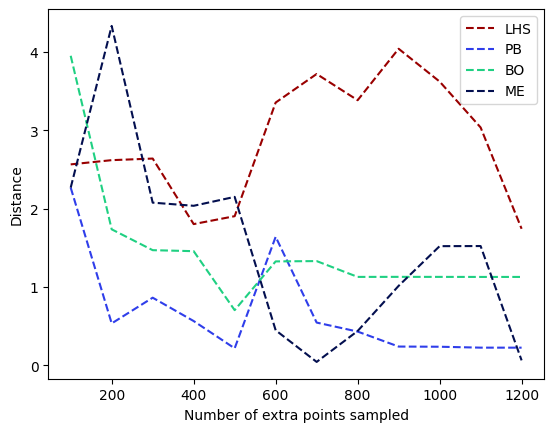

In [23]:
plt.plot(np.linspace(100,1200,N_POINTS_METRICS), metrics_lhs[2], '--', label='LHS')
plt.plot(np.linspace(100,1200,N_POINTS_METRICS), metrics_pb[2], '--', label='PB')
plt.plot(np.linspace(100,1200,N_POINTS_METRICS), metrics_bo[2], '--', label='BO')
plt.plot(np.linspace(100,1200,N_POINTS_METRICS), metrics_me[2], '--', label='ME')
plt.xlabel('Number of extra points sampled')
plt.ylabel('Distance')
plt.legend()
plt.show()

<Axes: xlabel='Optimization', ylabel='Distance'>

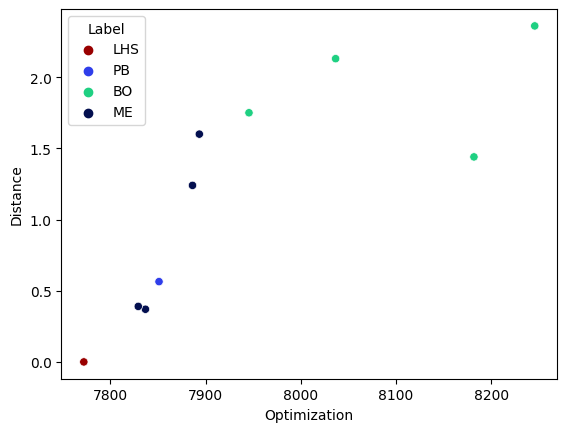

In [24]:
metrics = pd.read_csv('data/out/trade_off.csv')
sns.scatterplot(data=metrics, x='Optimization', y='Distance', hue='Label')

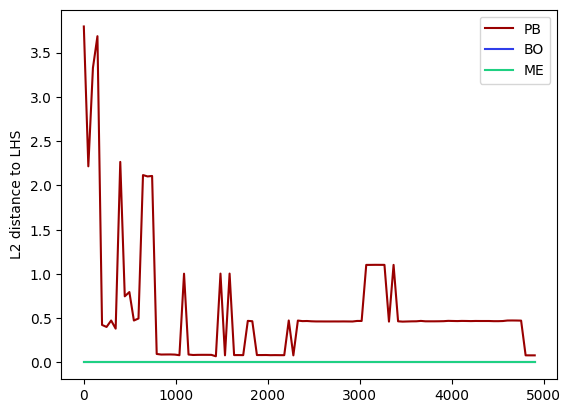

In [25]:
plt.plot(extra_points, distance[0,:], label='PB')
plt.plot(extra_points, distance[1,:], label='BO')
plt.plot(extra_points, distance[2,:], label='ME')
plt.ylabel('L2 distance to LHS')
plt.legend()
